Considerando un dataset extraído de la api "oanda", que contiene el histórico de la variación por hora del valor de diferentes pares de monedas (EUR-USD, AUD-USD, etc), se propone lo siguiente: 

* Desarrollar un modelo ARIMA que permita predecir el precio de las monedas en días futuros (forecasting). 
sólo para una moneda por ejemplo, Euro - Dólar.

In [24]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
import os
import math 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
plt.style.use('ggplot')
from pmdarima import auto_arima  
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet

In [37]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.6.0-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached holidays-0.21.13-py3-none-any.whl (378 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached pysimdjson-5.0.2-cp310-cp310-win_amd64.whl (155 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached aiohttp-3.8.4-cp310-cp310-win_amd64.whl (319 kB)
  Using cached pystan-3.5.0-py3-none-any.whl (13 kB)
  Using cached pysimdjson-3.2.0.tar.gz (411 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pystan-3.4.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.3.0-py3-none-any.whl (13 kB)
  Us

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [53 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib
      creating build\lib\fbprophet
      creating build\lib\fbprophet\stan_model
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\mpire\AppData\Local\Temp\pip-install-scw5y37h\fbprophet_dd7baa50b20c45d3b78e0b3336533c4b\setup.py", line 122, in <module>
          setup(
        File "C:\Users\mpire\anaconda3\envs\DH\lib\site-packages\setuptools\__init__.py", line 87, in setup
          return distutils.core.setup(**attrs)
        File "C:\Users\mpire\anaconda3\envs\DH\lib\site-packages\setuptools\_distutils\core.py", line 185, in setup
          return run_commands(dist)
        File "C:\Users\mpire\anaconda3\envs\D

## 1. Lectura del Dataframe 

In [3]:
datos = pd.read_csv(r'EUR_USD_H1.csv')
print(datos.head)
print(f'El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 



<bound method NDFrame.head of                    time  open_bid  high_bid  low_bid  close_bid  open_ask  \
0      2015-01-28 02 AM   1.13343   1.13398  1.13299    1.13338   1.13358   
1      2015-01-28 03 AM   1.13335   1.13429  1.13335    1.13397   1.13352   
2      2015-01-28 04 AM   1.13399   1.13413  1.13317    1.13362   1.13414   
3      2015-01-28 05 AM   1.13358   1.13632  1.13329    1.13547   1.13373   
4      2015-01-28 06 AM   1.13544   1.13815  1.13524    1.13693   1.13561   
...                 ...       ...       ...      ...        ...       ...   
49995  2023-02-09 09 PM   1.07328   1.07380  1.07323    1.07380   1.07342   
49996  2023-02-09 10 PM   1.07345   1.07408  1.07345    1.07391   1.07421   
49997  2023-02-09 11 PM   1.07392   1.07412  1.07373    1.07384   1.07434   
49998        2023-02-10   1.07385   1.07386  1.07248    1.07341   1.07402   
49999  2023-02-10 01 AM   1.07340   1.07349  1.07304    1.07339   1.07355   

       high_ask  low_ask  close_ask  
0      

In [15]:
datos_a = datos[['open_bid', 'time']]
datos_a.head()

open_bid              time
0   1.13343  2015-01-28 02 AM
1   1.13335  2015-01-28 03 AM
2   1.13399  2015-01-28 04 AM
3   1.13358  2015-01-28 05 AM
4   1.13544  2015-01-28 06 AM

## 2. Descripción breve del DataFrame.

El DataFrame en estudio cuenta con 9  columnas y un total de 50000 filas. 

Las columnas contenidas en el DataFrame son: 

2.1 time: Hora en de apertura para cada periodo.

2.2 open_bid : Precio de apertura para la venta  a la hora indicada. 

2.3 high_bid : Precio más alto de venta del usuario para esa hora. 

2.4 low_bid : Precio más bajo de venta del usuario para esa hora.

2.5 close_bid: Precio de cierre para la venta a la hora indicada.

2.6 open_ask : Precio de apertura para la compra a la hora indicada. 

2.7 high_ask : Precio más alto de compra para el usuario para esa hora. 

2.8 low_ask : Precio más bajo de compra para usuario para esa hora.

2.9 close_ask : Precio de cierre para la compra a la hora indicada.

In [16]:
# Cambio de columna a datetime
df['time'] = pd.to_datetime(df['time'])
df.index = df.time
df_ARIMA = df.drop(['time'], axis = 1)

C:\Users\mpire\AppData\Local\Temp\ipykernel_20076\105100614.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



open_bid
time                         
2015-01-28 02:00:00   1.13343
2015-01-28 03:00:00   1.13335
2015-01-28 04:00:00   1.13399
2015-01-28 05:00:00   1.13358
2015-01-28 06:00:00   1.13544

In [17]:
# Resample del DataFrame , calculando open_bid promedio por día. 
df = datos_ARIMA.resample('D').agg({'open_bid':'mean'})
df.head()

open_bid
time                
2015-01-28  1.133460
2015-01-29  1.130125
2015-01-30  1.131697
2015-01-31       NaN
2015-02-01  1.130895

In [18]:
# Para saber si existen valores nulos
df.isnull().sum()
# Eliminar valores nulos 
df.dropna(inplace=True)

In [8]:
# Eliminar valores nulos 
exchange_rate = exchange_rate_1.dropna()

In [19]:
df["timeIndex"] = pd.Series(np.arange(len(df['open_bid'])), index=df.index)
df['log_value'] = np.log(df['open_bid'])

df['month'] = [d.strftime('%b') for d in df.index]
dummies_mes = pd.get_dummies(df['month'])
df = df.join(dummies_mes)

## 3. Distribución de los datos.  

<AxesSubplot: >

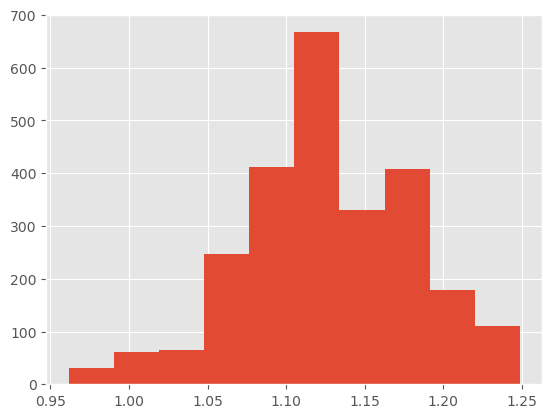

In [21]:
df.open_bid.hist()

### Variación temporal de la relación del precio de apertura entre EUR-USD

In [13]:
fig = px.line(exchange_rate, x = exchange_rate.index, y = exchange_rate.open_bid, template = "plotly_dark",
            title = 'Variación de precio de apertura entre EUR y USD')
fig.show()

### División en train y test 

In [22]:
# Usaremos el 70% de los datos para train y el restante para test. 

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42, shuffle=False)

In [25]:
model_log_est = smf.ols('log_value ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [26]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [27]:
# Recuperamos el valor predicho aplicando la función exponencial sobre las predicciones.
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

## Probamos primero si los residuos del modelo en la serie original son estacionarios

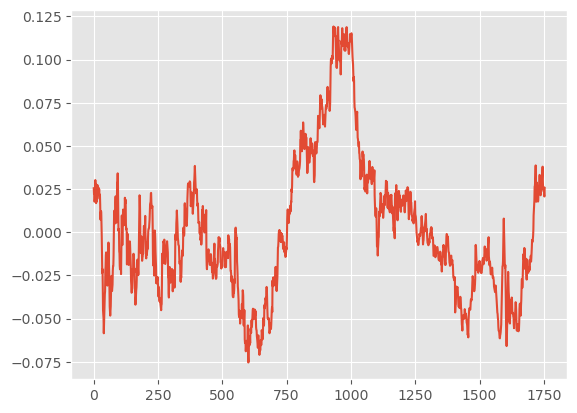

In [28]:
res_model = df_train['open_bid'] - df_train['back_model_log_est']

plt.plot(df_train.timeIndex, res_model, '-');

In [29]:
# Testeamos la estacionariedad de los residuos:

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.814833
p-value: 0.056186
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


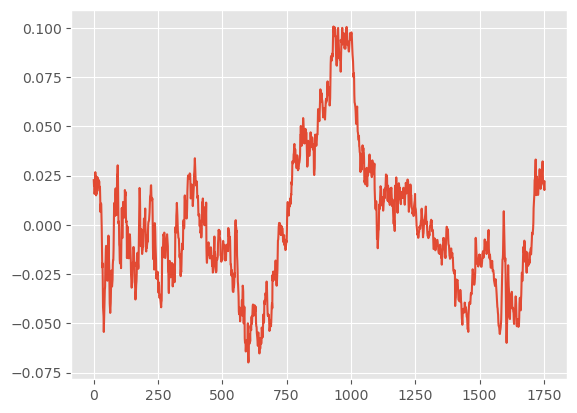

In [30]:
res_log_est = df_train['log_value'] - df_train['model_log_est']

plt.plot(df_train.timeIndex, res_log_est, '-');

In [31]:
result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.878342
p-value: 0.047925
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


Podemos rechazar la hipótesis nula y los residuos de la serie es estacionaria

Calculamos la ACF para res_log con 750 rezagos:

In [32]:
lag_acf = acf(res_log_est, nlags = 750)
lag_acf

array([ 1.        ,  0.99345218,  0.98365649,  0.97380513,  0.96438576,
        0.95526574,  0.94640774,  0.93792419,  0.93021527,  0.92334316,
        0.91697016,  0.91065608,  0.90447116,  0.89862875,  0.8928933 ,
        0.88705478,  0.88175978,  0.87725234,  0.87327481,  0.86920335,
        0.8654093 ,  0.86182521,  0.85874036,  0.85607934,  0.8530193 ,
        0.84947925,  0.84605606,  0.8426894 ,  0.83865475,  0.83390539,
        0.82879202,  0.82354574,  0.81868831,  0.8139291 ,  0.80910986,
        0.80433221,  0.79957516,  0.79492886,  0.78999657,  0.78542517,
        0.78101651,  0.77692357,  0.7731027 ,  0.76916346,  0.76506651,
        0.76084091,  0.75643474,  0.75143282,  0.74576617,  0.73960228,
        0.73315682,  0.72718266,  0.72158849,  0.71665194,  0.71232756,
        0.70847207,  0.70456892,  0.70082998,  0.6971596 ,  0.6937366 ,
        0.6904334 ,  0.68661191,  0.68240102,  0.67773104,  0.67263146,
        0.66747309,  0.66261142,  0.65804799,  0.65344745,  0.64

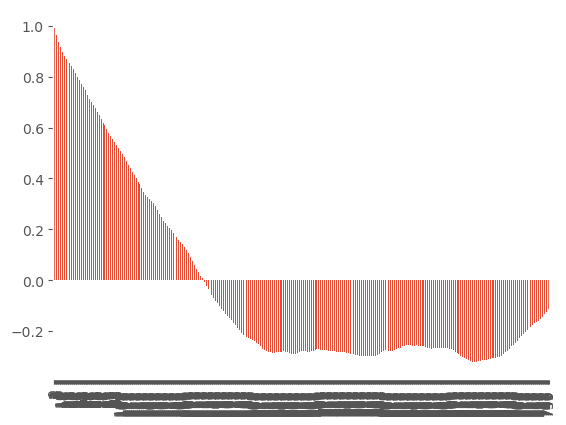

In [33]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

Calculamos la PACF para res_log con 750 rezagos. Usamos mínimos cuadrádos ordinarios para estimar los parámetros:

In [34]:
lag_pacf = pacf(res_log_est, nlags=750, method='ols');

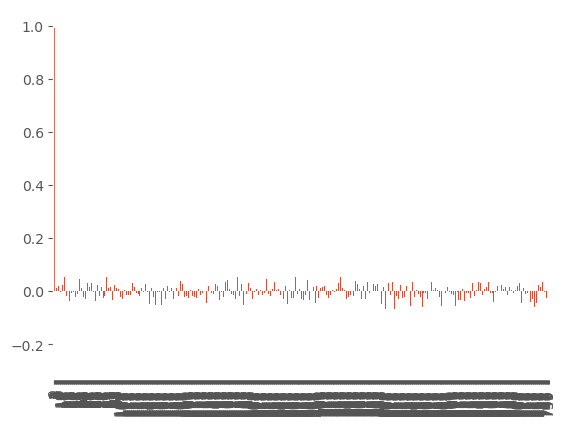

In [35]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");